In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rasterio as rio

import pandas as pd
import geopandas as gpd

from pathlib import Path
from osgeo import gdal
from pyproj import Proj, Transformer
from rasterio import plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.interpolate import RegularGridInterpolator, griddata
from matplotlib.colors import LightSource, ListedColormap

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import caesarpy as cp

### Catchment DEM

Get the DEM of the catchment to get the bounds of the catchment so that the grain size from inside the catchment is used.

In [2]:
path_to_tif = Path('./tet/')

In [3]:
dem_asc = path_to_tif/'dem_200m_preproc.asc'
nx, ny, geotransform, dem = cp.asc2numpy(str(dem_asc))

In [4]:
ul = (geotransform[0], geotransform[3])
lr = (geotransform[0] + nx * geotransform[1], geotransform[3] + ny * geotransform[5])
ll = (geotransform[0], geotransform[3] + ny * geotransform[5])

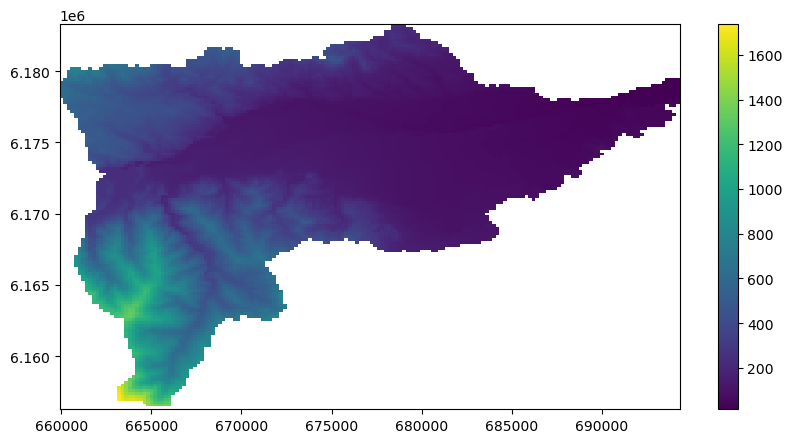

In [5]:
dx = geotransform[1]

x = np.linspace(ll[0], ll[0] + dx * (nx -1), nx)
y = np.linspace(ll[1] + dx * (ny -1), ll[1], ny)
X,Y = np.meshgrid(x, y, indexing='xy')

plt.figure(figsize=[10,5])
plt.subplot(111)
plt.pcolormesh(X, Y, dem)
plt.colorbar()
plt.show()

### Coordinate transformation

Transform the coordinates to WGS84 as it is easier to work with when pulling the SoilGirds tiles

In [6]:
transproj = Transformer.from_crs('EPSG:2154', 'EPSG:4326', always_xy=True)

In [7]:
x = np.zeros((2,))
y = np.zeros((2,))
for i, pt in enumerate(transproj.itransform([ul, lr])):
    x[i], y[i] = pt
    print('{:.3f} {:.3f}'.format(*pt))

2.512 42.749
2.932 42.507


### Geopandas data for population density

https://www.insee.fr/fr/statistiques/6215140?sommaire=6215217#dictionnaire

In [8]:
ascifile = 'tet/pop_200m_res200m.asc'
res = 200

if os.path.isfile(ascifile) is False: 

    #df = gpd.read_file('/work/armitagj/code/pop-density/Filosofi2017_carreaux_1km_met.gpkg')
    df = gpd.read_file('/work/armitagj/code/pop-density/Filosofi2017_carreaux_200m_met.gpkg')
    df.plot(column='Ind')
    c = np.stack([df.centroid.x, df.centroid.y, df.Ind], axis=1)
    
    i = np.argsort(c[:, 0])
    
    x = c[i, 0]
    y = c[i, 1]
    z = c[i, 2]
    
    del(df)
    
    POP = griddata((x, y), z, (X, Y), method='nearest')
    POP[np.isnan(dem)] = np.nan

    cp.numpy2asc(POP, res, ascifile)

    del(c, x, y, z)

In [9]:
if os.path.isfile(ascifile):
    nx, ny, geotransform, POP = cp.asc2numpy(ascifile)

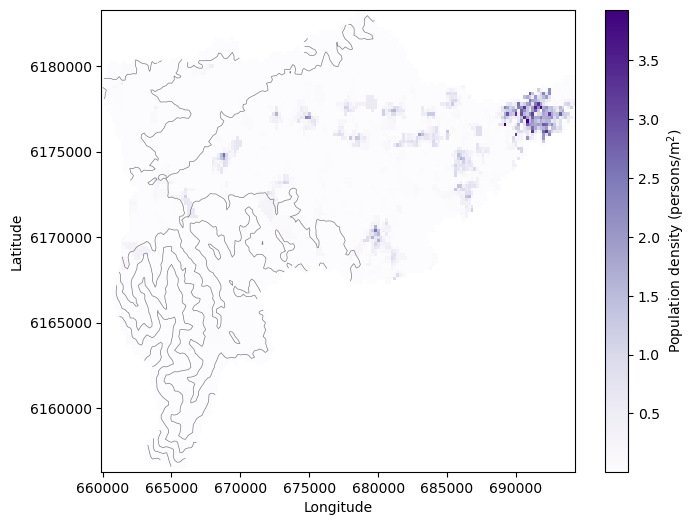

In [10]:
ls = LightSource(azdeg=0, altdeg=125)
bumps = ls.hillshade(dem) #**0.25

mi, ma = np.floor(np.nanmin(dem)), np.ceil(np.nanmax(dem))
levels = np.arange(mi, ma, 200)

fig, ax = plt.subplots(figsize=[6 * nx / ny, 6])
pc = ax.pcolormesh(X, Y, POP / 200, cmap='Purples')
plt.colorbar(pc, label='Population density (persons/m$^2$)')
ax.contour(X, Y, dem, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
ax.ticklabel_format(style='plain')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('tet/pop-density.png', dpi=300)
plt.show()

### Make simple plastic regions

In [11]:
Plastic = np.ones(np.shape(POP))

for i in range(nx):
    for j in range(ny):
        if POP[j, i] > 0:
            if POP[j, i] / 200 <= .5:
                Plastic[j, i] = 1
            if POP[j, i] / 200 > .5 and POP[j, i] / 200 <= 2:
                Plastic[j, i] = 2
            if POP[j, i] / 200 > 2:
                Plastic[j, i] = 3
Plastic[np.isnan(dem)] = np.nan

/tmp/ipykernel_21415/1500207949.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.pcolormesh(X, Y, Plastic, cmap=plt.cm.get_cmap('Reds', 3))


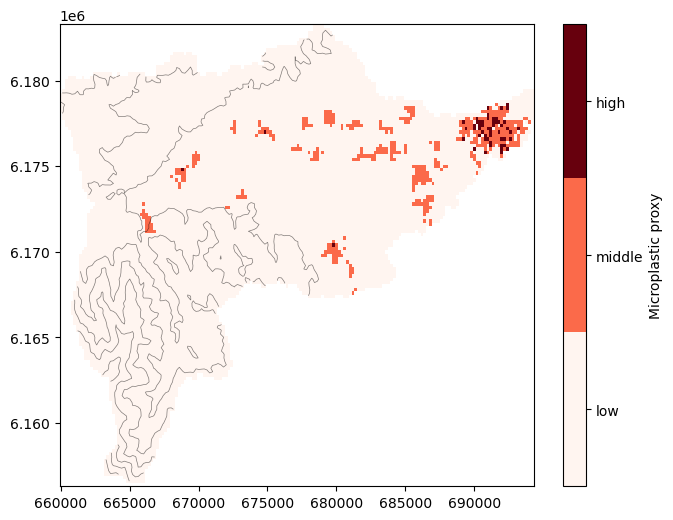

In [12]:
plt.figure(figsize=[6 * nx / ny, 6])
plt.pcolormesh(X, Y, Plastic, cmap=plt.cm.get_cmap('Reds', 3))

names = ['none', 'low', 'middle', 'high']
formatter = plt.FuncFormatter(lambda val, loc: names[val])
plt.colorbar(ticks=[0, 1, 2, 3], format=formatter, label='Microplastic proxy')
plt.clim(0.5, 3.5)

plt.contour(X, Y, dem, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.savefig('tet/plastic-source.png', dpi=300)
plt.show()

In [13]:
ascifile = 'tet/plastic-source-200m.asc'
cp.numpy2asc(Plastic, res, ascifile)

In [14]:
np.shape(dem)

(135, 172)

### Resample to a 50 m DEM

In [15]:
dem_asc = path_to_tif/'dem_050m_preproc.asc'
nx, ny, geotransform, dem = cp.asc2numpy(str(dem_asc))

In [16]:
ul = (geotransform[0], geotransform[3])
lr = (geotransform[0] + nx * geotransform[1], geotransform[3] + ny * geotransform[5])
ll = (geotransform[0], geotransform[3] + ny * geotransform[5])

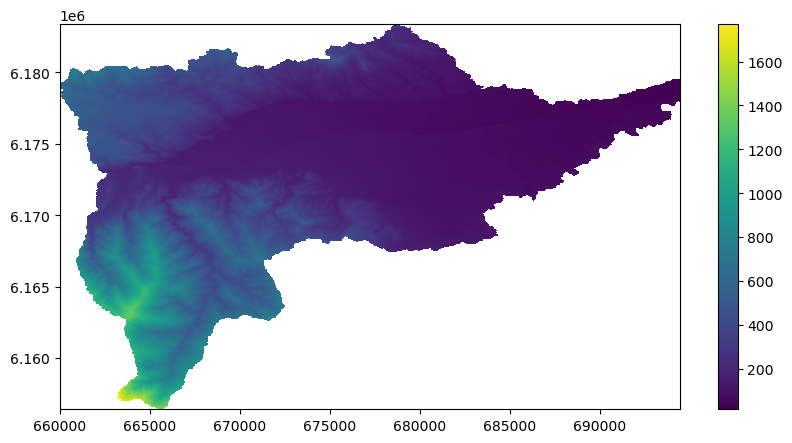

In [17]:
dx = geotransform[1]

x50 = np.linspace(ll[0], ll[0] + dx * (nx -1), nx)
y50 = np.linspace(ll[1] + dx * (ny -1), ll[1], ny)
X50, Y50 = np.meshgrid(x50, y50, indexing='xy')

plt.figure(figsize=[10,5])
plt.subplot(111)
plt.pcolormesh(X50, Y50, dem)
plt.colorbar()
plt.show()

In [18]:
Plastic[np.isnan(Plastic)] = 0
Plastic50 = griddata((X.flatten(), Y.flatten()), Plastic.flatten(), (X50, Y50), method='nearest')

In [19]:
Plastic50[np.isnan(dem)] = np.nan
Plastic50[Plastic50 == 0] = 1

/tmp/ipykernel_21415/1152394169.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.pcolormesh(X50, Y50, Plastic50, cmap=plt.cm.get_cmap('Reds', 3))


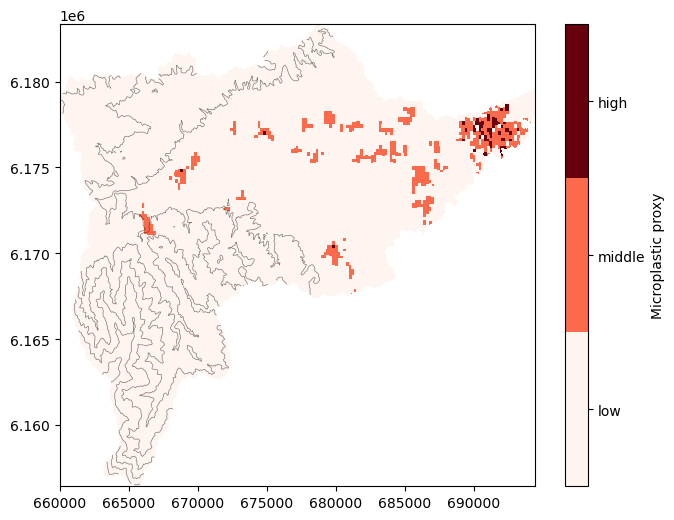

In [20]:
plt.figure(figsize=[6 * nx / ny, 6])
plt.pcolormesh(X50, Y50, Plastic50, cmap=plt.cm.get_cmap('Reds', 3))

names = ['none', 'low', 'middle', 'high']
formatter = plt.FuncFormatter(lambda val, loc: names[val])
plt.colorbar(ticks=[0, 1, 2, 3], format=formatter, label='Microplastic proxy')
plt.clim(0.5, 3.5)

plt.contour(X50, Y50, dem, levels=levels, linewidths=0.5, colors=[(0,0,0,0.5)])
plt.savefig('tet/plastic-source-50m.png', dpi=300)
plt.show()

In [21]:
res = 50
ascifile = 'tet/plastic-source-050m.asc'
cp.numpy2asc(Plastic50, res, ascifile)

In [22]:
np.shape(dem)

(539, 689)

In [23]:
np.shape(Plastic50)

(539, 689)

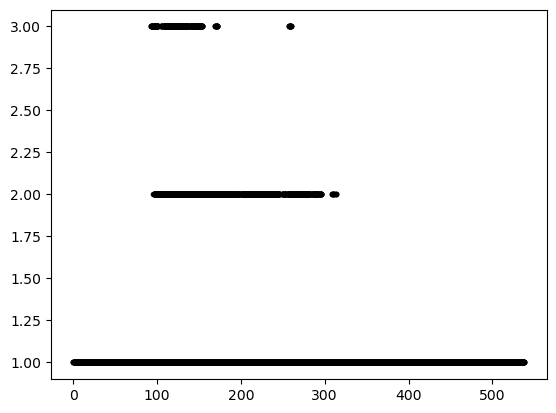

In [24]:
plt.figure()
plt.plot(Plastic50, '.k')
plt.show()